定义原始模型

载入dataset

In [ ]:
# x = torch.randn(5, 3, 256, 256)
# c = torch.randn(1024,1,16)

from torch.utils.data import DataLoader

fmri_latents_dataset_train, fmri_latents_dataset_test = create_Kamitani_dataset(config.kam_path, config.roi, config.patch_size, 
                fmri_transform=fmri_transform, image_transform=[img_transform_train, img_transform_test], 
                subjects=config.kam_subs)  
dataset = fmri_latents_dataset_train
dataloader = DataLoader(dataset, batch_size=5, shuffle=True) 
for batch in dataloader:
    print('forward on')
    out = stageC_model(batch)
    print('forward end')
# y = stageC_model(x, c)

定义PD_Norm

In [1]:
import torch
from pdnorm_model import PDfLDM
from omegaconf import OmegaConf

config = OmegaConf.load('./code/stageC_config.yaml')
pd_model = PDfLDM(**config.model.params)



PDfLDM: Running in eps-prediction mode
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
------------------------------------------------
PDfLDM:                            597.0 M
      Trainable     params:        544.3 M
      Non-trainable params:         52.8 M
  Module: PDDiffusionWrapper
      Trainable     params:        385.0 M
      Non-trainable params:          0.0 M
------------------------------------------------
  Module: VQModelInterface
      Trainable     params:          0.0 M
      Non-trainable params:         52.8 M
------------------------------------------------
  Module: PDCondStageModel
      Trainable     params:        159.3 M
      Non-trainable params:          0.0 M
------------------------------------------------


In [2]:
checkpoint_path = './results/generation/07-09-2023-01-50-29/checkpoint_best.pth'
model_meta = torch.load(checkpoint_path, map_location='cpu')
pd_model.state_from_fLDM(model_meta['model_state_dict'])
unfreezed_params = pd_model.unfreeze_stageC_params(True) # True-->28.2M; False-->26.2M

****************************** State dict are successfully loaded! ******************************
------------------------------------------------
PDfLDM:                            597.0 M
      Trainable     params:        187.5 M
      Non-trainable params:        409.5 M
  Module: PDDiffusionWrapper
      Trainable     params:         28.2 M
      Non-trainable params:        356.8 M
------------------------------------------------
  Module: VQModelInterface
      Trainable     params:          0.0 M
      Non-trainable params:         52.7 M
------------------------------------------------
  Module: PDCondStageModel
      Trainable     params:        159.3 M
      Non-trainable params:          0.0 M
------------------------------------------------


In [6]:
batch = {'fmri': torch.rand(5,4656),'image': torch.rand(5,256,256,3)}
z,c = pd_model.get_input(batch,key='image')

In [22]:
beta_schedule="linear"
n_timestep=1000
linear_start=1e-4
linear_end=2e-2
cosine_s=8e-3

betas =  torch.linspace(linear_start ** 0.5, linear_end ** 0.5, n_timestep, dtype=torch.float64) ** 2

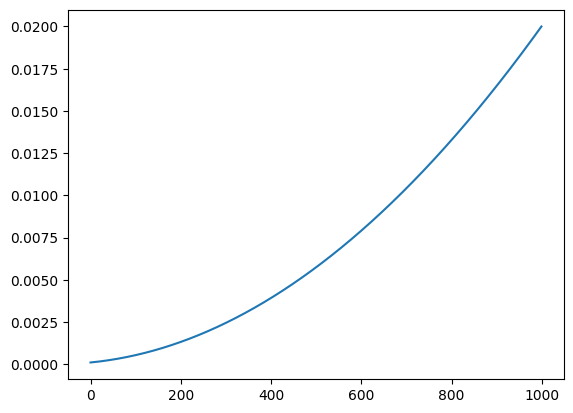

In [23]:
from matplotlib.pyplot import plot
plot(betas)

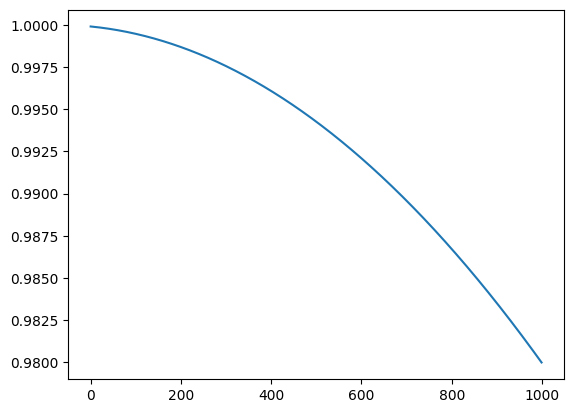

In [24]:
import numpy as np
alphas = 1. - betas
plot(alphas)

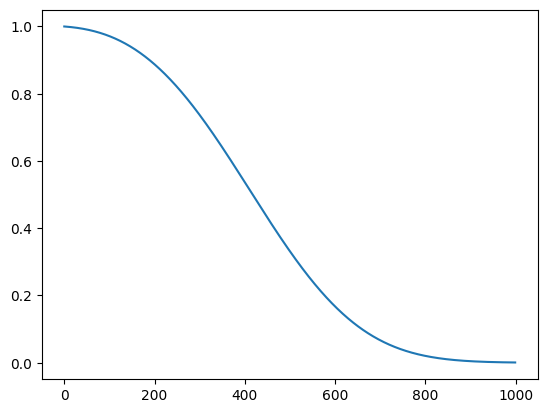

In [25]:
alphas_cumprod = np.cumprod(alphas, axis=0)
plot(alphas_cumprod)

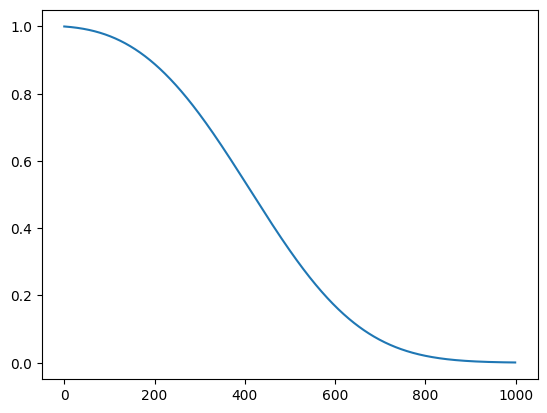

In [26]:
alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])
plot(alphas_cumprod_prev)

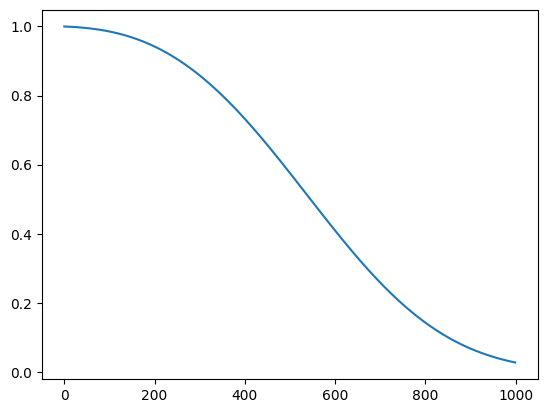

In [27]:
sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
plot(sqrt_alphas_cumprod)

In [2]:
a = 1024
b = (a,)
c = tuple(b)
print(c)

(1024,)


In [ ]:
def image_transform(self, img, subset):
    if subset == 'train':
        random_crop = transforms.RandomCrop(size=int(0.8*256)) if torch.rand(1)<0.5 else self.identity
        transform_func = transforms.Compose([self.normalize,
                                                random_crop,
                                                transforms.Resize((256, 256)), 
                                                self.channel_last])
    elif subset == 'valid':
        transform_func = transforms.Compose([self.normalize, 
                                        transforms.Resize((256, 256)), 
                                        self.channel_last])
    return transform_func(img)

x = torch.randint(0,255,(3,256,256))